### Label Confounding on X-ray data

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# ATE estimation
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from causalml.inference.meta import BaseSRegressor
from doubleml import DoubleMLData, DoubleMLPLR
import statsmodels.api as sm

# Custom modules
from feature_extraction.pretrained_models_xrv import load_torchxrayvision_model, extract_features_from_folder
from utils.project import set_root
from utils.io import save_results, load_results

In [ ]:
# Set working directory, dataset directory and directory for saving results
set_root()
dataset_dir = "data/pneumonia/all_unique"
results_dir = "results/comparison_learners/xray/label"

# Define the model name and path for saving results
model_name = "densenet121-res224-all"  # Pretrained model name
save_dir_rep = f"data/representations/pneumonia/{model_name}"

# Define file paths
features_path = os.path.join(save_dir_rep, "latent_features.npy")
labels_path = os.path.join(save_dir_rep, "labels.npy")

In [ ]:
# Feature extraction and saving (Only if the features and labels do not already exist)
if not os.path.exists(features_path) or not os.path.exists(labels_path):
    print(f"Extracting features using model '{model_name}'...")
    
    # Extract features and save them
    model = load_torchxrayvision_model(model_name)
    all_features, labels = extract_features_from_folder(
        dataset_dir,
        model,
        device='cpu',
        batch_size=32,
        save_path=save_dir_rep
    )
    
    print(f"Features extracted and saved to: {save_dir_rep}")
else:
    print(f"Features already exist in {save_dir_rep}. Skipping extraction.")

# Load extracted features
all_features = np.load(features_path)
labels = np.load(labels_path)

### Confounding Simulation and ATE Estimation

In [ ]:
# 1. Define simulation parameters
beta_true = 2.0     # True effect of A on Y
gamma_true = -2   # Effect of pneumonia on Y
p_treat_given_pneu = 0.7    # Probability of treatment if pneumonia
p_treat_given_normal = 0.3  # Probability of treatment if normal

# 2. Specify general parameters for simulation
pneumonia_label = labels.astype(int) # ensure 0/1
n_samples = pneumonia_label.shape[0]
n_runs = 5  # Number of simulation runs
ci_alpha_level = 0.05  # Alpha level for 1-alpha confidence intervals
z_score = norm.ppf(1 - ci_alpha_level / 2) # Z-score for 1-alpha confidence intervals

# 3. Initialize dictionaries to store estimates and confidence intervals
methods = ['Naive', 'Oracle', 'S-Learner (Linear)', 'S-Learner (RF)', 'S-Learner (Lasso)', 'DML (Linear)', 'DML (RF)', 'DML (Lasso)']
estimates_dict = {method: [] for method in methods}
cis_dict = {method: {'lower': [], 'upper': []} for method in methods}

# Set seed for reproducibility
seed = 42

# 4. Simulation Loop
for run in range(n_runs):
    print(f"\n--- Simulation Run {run + 1} ---")
    # Set a unique seed for each run for variability
    seed = seed + 2  # Update seed for each run
    np.random.seed(seed)
    
    # 4.1. Simulate Treatment A
    pA = pneumonia_label * p_treat_given_pneu + (1 - pneumonia_label) * p_treat_given_normal
    A = np.random.binomial(1, pA)
    
    # 4.2. Simulate Outcome Y
    noise = np.random.normal(loc=0, scale=1, size=n_samples)
    Y = beta_true * A + gamma_true * pneumonia_label + noise
    
    # 4.3. Package into DataFrame
    df = pd.DataFrame({
        'Y': Y,
        'A': A,
        'pneumonia': pneumonia_label
    })
    
    # 4.4. Naive OLS (Unadjusted) using statsmodels
    X_naive = sm.add_constant(df['A']) 
    model_naive = sm.OLS(df['Y'], X_naive).fit()
    beta_naive = model_naive.params['A']
    se_naive = model_naive.bse['A']
    ci_lower_naive = beta_naive - z_score * se_naive
    ci_upper_naive = beta_naive + z_score * se_naive
    estimates_dict['Naive'].append(beta_naive)
    cis_dict['Naive']['lower'].append(ci_lower_naive)
    cis_dict['Naive']['upper'].append(ci_upper_naive)
    print(f"Naive OLS: β = {beta_naive:.3f}, SE = {se_naive:.3f}")
    
    # 4.5. Oracle OLS (Adjusting for pneumonia label) using statsmodels
    X_oracle = sm.add_constant(df[['A', 'pneumonia']])
    model_oracle = sm.OLS(df['Y'], X_oracle).fit()
    beta_oracle = model_oracle.params['A']
    se_oracle = model_oracle.bse['A']
    ci_lower_oracle = beta_oracle - z_score * se_oracle
    ci_upper_oracle = beta_oracle + z_score * se_oracle
    estimates_dict['Oracle'].append(beta_oracle)
    cis_dict['Oracle']['lower'].append(ci_lower_oracle)
    cis_dict['Oracle']['upper'].append(ci_upper_oracle)
    print(f"Oracle OLS: β = {beta_oracle:.3f}, SE = {se_oracle:.3f}")

    # 4.6.1. S-Learner (Linear)
    outcome_model_linear = LinearRegression()
    try:
        outcome_model_linear = BaseSRegressor(outcome_model_linear) 
        s_ate_linear, s_ci_lower_linear , s_ci_upper_linear  = outcome_model_linear.estimate_ate(all_features, A, Y, return_ci=True)
        estimates_dict['S-Learner (Linear)'].append(s_ate_linear[0])
        cis_dict['S-Learner (Linear)']['lower'].append(s_ci_lower_linear[0])
        cis_dict['S-Learner (Linear)']['upper'].append(s_ci_upper_linear[0])
        print(f"S-Learner (Linear): β = {s_ate_linear[0]:.3f}")
    except Exception as e:
        print(f"Run {run+1}: S-Learner (Linear) failed with error: {e}")
        estimates_dict['S-Learner (Linear)'].append(np.nan)
        cis_dict['S-Learner (Linear)']['lower'].append(np.nan)
        cis_dict['S-Learner (Linear)']['upper'].append(np.nan)
    
    # 4.6.2. S-Learner (RF) 
    outcome_model_rf = RandomForestRegressor(n_estimators=50, random_state=42)
    try:
        s_learner_rf = BaseSRegressor(outcome_model_rf) 
        s_ate_rf, s_ci_lower_rf, s_ci_upper_rf = s_learner_rf.estimate_ate(all_features, A, Y, return_ci=True)
        estimates_dict['S-Learner (RF)'].append(s_ate_rf[0])
        cis_dict['S-Learner (RF)']['lower'].append(s_ci_lower_rf[0])
        cis_dict['S-Learner (RF)']['upper'].append(s_ci_upper_rf[0])
        print(f"S-Learner (RF): β = {s_ate_rf[0]:.3f}")
    except Exception as e:
        print(f"Run {run+1}: S-Learner (RF) failed with error: {e}")
        estimates_dict['S-Learner (RF)'].append(np.nan)
        cis_dict['S-Learner (RF)']['lower'].append(np.nan)
        cis_dict['S-Learner (RF)']['upper'].append(np.nan)

    # 4.6.3. S-Learner (Lasso) 
    outcome_model_lasso = LassoCV(cv=5, n_jobs=-1)
    try:
        s_learner_lasso = BaseSRegressor(outcome_model_lasso) 
        s_ate_lasso, s_ci_lower_lasso, s_ci_upper_lasso = s_learner_lasso.estimate_ate(all_features, A, Y, return_ci=True)
        estimates_dict['S-Learner (Lasso)'].append(s_ate_lasso[0])
        cis_dict['S-Learner (Lasso)']['lower'].append(s_ci_lower_lasso[0])
        cis_dict['S-Learner (Lasso)']['upper'].append(s_ci_upper_lasso[0])
        print(f"S-Learner (Lasso): β = {s_ate_lasso[0]:.3f}")
    except Exception as e:
        print(f"Run {run+1}: S-Learner (Lasso) failed with error: {e}")
        estimates_dict['S-Learner (Lasso)'].append(np.nan)
        cis_dict['S-Learner (Lasso)']['lower'].append(np.nan)
        cis_dict['S-Learner (Lasso)']['upper'].append(np.nan)

    # 4.7. DoubleML with Linar and Random Forest Nuisance Estimators
    # Convert all_features to DataFrame
    X_dml_df = pd.DataFrame(
        all_features,
        columns=[f"feat_{i}" for i in range(all_features.shape[1])]
    )

    # Add outcome and treatment to DoubleMLData via column names
    X_dml_df['Y'] = df['Y'].copy()
    X_dml_df['A'] = df['A'].copy()

    # Create DoubleMLData
    data_dml = DoubleMLData(X_dml_df, "Y", "A")

    # 4.7.1. DoubleML with Linear Models Estimators
    try:
        # Define nuisance models with linear models
        ml_g_linear = LinearRegression() # Outcome model
        ml_m_linear = LogisticRegression()  # Treatment model

    
        # Instantiate and fit DoubleMLPLR
        dml_plr_linear = DoubleMLPLR(data_dml, ml_g_linear, ml_m_linear, n_folds=2) 
        dml_plr_linear.fit()
        beta_dml_linear = dml_plr_linear.coef[0]
        se_dml_linear = dml_plr_linear.se[0]
        estimates_dict['DML (Linear)'].append(beta_dml_linear)
        # 95% Confidence Interval
        ci_lower_dml_linear = beta_dml_linear - z_score * se_dml_linear
        ci_upper_dml_linear = beta_dml_linear + z_score * se_dml_linear
        cis_dict['DML (Linear)']['lower'].append(ci_lower_dml_linear)
        cis_dict['DML (Linear)']['upper'].append(ci_upper_dml_linear)
        print(f"DML (Linear): β = {beta_dml_linear:.3f}, SE = {se_dml_linear:.3f}")
    except Exception as e:
        print(f"Run {run+1}: DML (Linear) failed with error: {e}")
        estimates_dict['DML (Linear)'].append(np.nan)
        cis_dict['DML (Linear)']['lower'].append(np.nan)
        cis_dict['DML (Linear)']['upper'].append(np.nan)
    
    # 4.7.2. DoubleML with Random Forest Nuisance Estimators
    try:
        # Define nuisance models with neural networks
        ml_g_rf = RandomForestRegressor(n_estimators=50, random_state=42) 
        ml_m_rf = RandomForestClassifier(n_estimators=50, random_state=42)
    
        # Instantiate and fit DoubleMLPLR
        dml_plr_rf = DoubleMLPLR(data_dml, ml_g_rf, ml_m_rf, n_folds=2)  
        dml_plr_rf.fit()
        beta_dml_rf = dml_plr_rf.coef[0]
        se_dml_rf = dml_plr_rf.se[0]
        estimates_dict['DML (RF)'].append(beta_dml_rf)
        # 95% Confidence Interval
        ci_lower_dml_rf = beta_dml_rf - z_score * se_dml_rf 
        ci_upper_dml_rf = beta_dml_rf + z_score * se_dml_rf
        cis_dict['DML (RF)']['lower'].append(ci_lower_dml_rf)
        cis_dict['DML (RF)']['upper'].append(ci_upper_dml_rf)
        print(f"DML (RF): β = {beta_dml_rf:.3f}, SE = {se_dml_rf:.3f}")
    except Exception as e:
        print(f"Run {run+1}: DML failed with error: {e}")
        estimates_dict['DML (RF)'].append(np.nan)
        cis_dict['DML (RF)']['lower'].append(np.nan)
        cis_dict['DML (RF)']['upper'].append(np.nan)

    # 4.7.3. DoubleML with Lasso Nuisance Estimators
    try:
        # Define nuisance models with neural networks
        ml_g_lasso = LassoCV(cv=5, n_jobs=-1) 
        ml_m_lasso = LogisticRegression(penalty='l1', C=1, solver='saga', max_iter=10000)
    
        # Instantiate and fit DoubleMLPLR
        dml_plr_lasso = DoubleMLPLR(data_dml, ml_g_lasso, ml_m_lasso, n_folds=2)  
        dml_plr_lasso.fit()
        beta_dml_lasso = dml_plr_lasso.coef[0]
        se_dml_lasso = dml_plr_lasso.se[0]
        estimates_dict['DML (Lasso)'].append(beta_dml_lasso)
        # 95% Confidence Interval
        ci_lower_dml_lasso = beta_dml_lasso - z_score * se_dml_lasso 
        ci_upper_dml_lasso = beta_dml_lasso + z_score * se_dml_lasso
        cis_dict['DML (Lasso)']['lower'].append(ci_lower_dml_lasso)
        cis_dict['DML (Lasso)']['upper'].append(ci_upper_dml_lasso)
        print(f"DML (Lasso): β = {beta_dml_lasso:.3f}, SE = {se_dml_lasso:.3f}")
    except Exception as e:
        print(f"Run {run+1}: DML (Lasso) failed with error: {e}")
        estimates_dict['DML (Lasso)'].append(np.nan)
        cis_dict['DML (Lasso)']['lower'].append(np.nan)
        cis_dict['DML (Lasso)']['upper'].append(np.nan)

In [8]:
# 5. Create a directory for the experiment and save the results
experiment_name = "exp_results"
experiment_dir = os.path.join(results_dir, model_name, experiment_name)
save_results(experiment_dir, estimates_dict, cis_dict)

### Plotting Results

In [9]:
# Load the results from the previous experiment
estimates_dict, cis_dict = load_results(experiment_dir)

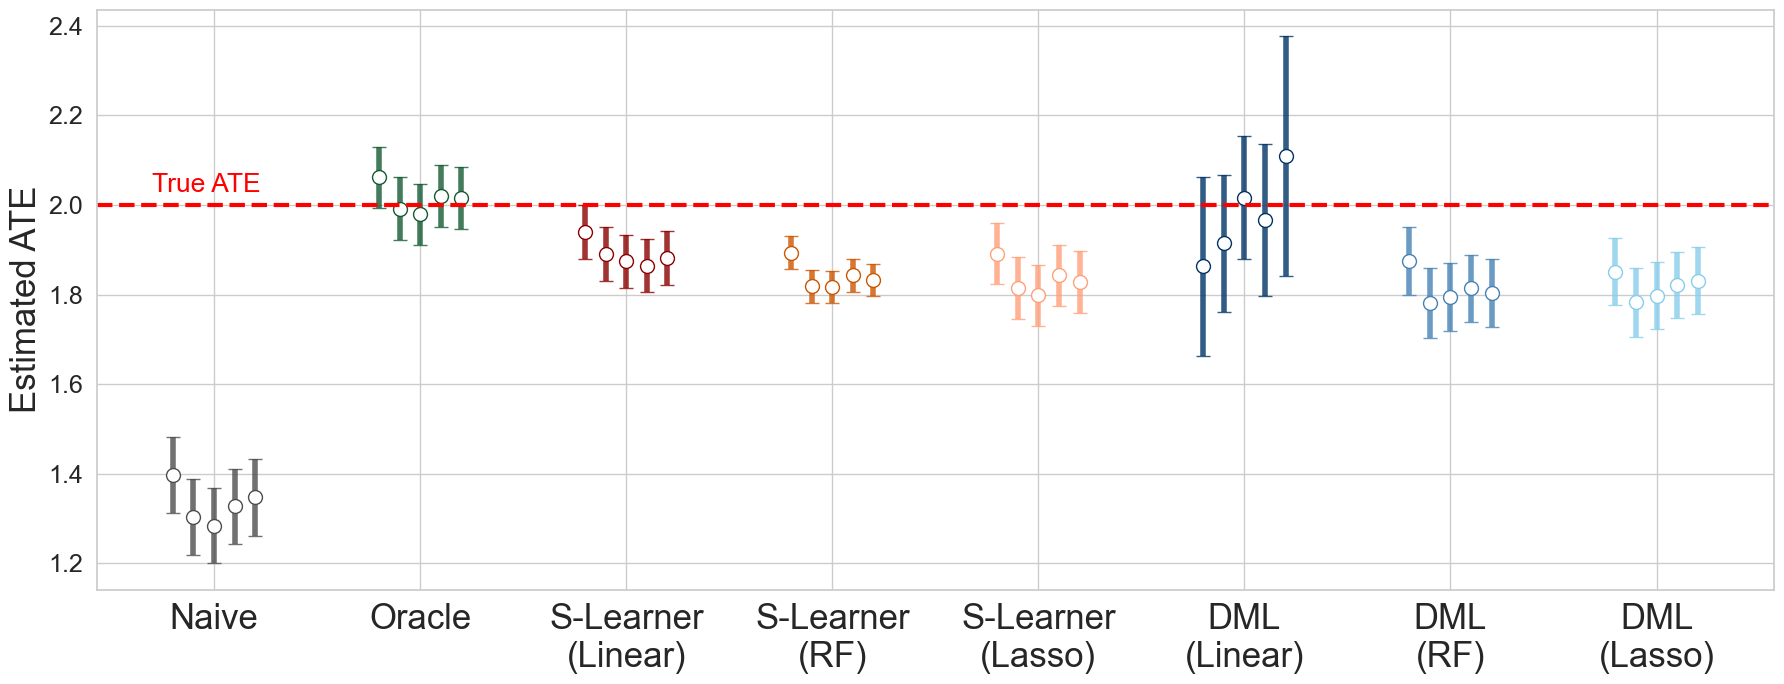

In [11]:
# 6. Aggregate Results
# Convert estimates_dict to DataFrame for easier manipulation
estimates_df = pd.DataFrame(estimates_dict)
cis_lower_df = pd.DataFrame({method: cis_dict[method]['lower'] for method in methods})
cis_upper_df = pd.DataFrame({method: cis_dict[method]['upper'] for method in methods})

# Prepare data for plotting
plot_data = []
for method in methods:
    for run in range(n_runs):
        if not np.isnan(estimates_df.loc[run, method]):
            plot_data.append({
                'Method': method,
                'Run': run + 1,
                'Estimate': estimates_df.loc[run, method],
                'CI Lower': cis_lower_df.loc[run, method],
                'CI Upper': cis_upper_df.loc[run, method]
            })

plot_df = pd.DataFrame(plot_data)

# 7. Plotting parameters
# Assign numerical positions to methods
method_positions = {method: idx for idx, method in enumerate(methods)}

# Define a consistent color palette
estimator_colors = {
    "Naive": "#4D4D4D", 
    "Oracle": "#145A32", 
    "S-Learner (Linear)": "#8B0000", 
    "S-Learner (RF)": "#CC5500",  
    "S-Learner (Lasso)": "#FFA07A",
    "DML (Linear)": "#003366",  
    "DML (RF)": "#4682B4",  
    "DML (Lasso)": "#87CEEB"
}

# 8. Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(18, 7), facecolor='white')
ax = plt.gca()

fontsize_plot = 25

# Define offsets for each run to spread the dots
offset_range = 0.2  # Total range for offsets
offsets = np.linspace(-offset_range, offset_range, n_runs)

# Plot each estimate with its confidence interval
for idx, row in plot_df.iterrows():
    method = row['Method']
    run = row['Run']
    x = method_positions[method] + offsets[run - 1]
    estimate = row['Estimate']
    ci_lower = row['CI Lower']
    ci_upper = row['CI Upper']
    color = estimator_colors.get(method, "black") 

    # Plot the confidence interval as a thicker error bar
    ax.errorbar(x, estimate, yerr=[[estimate - ci_lower], [ci_upper - estimate]],fmt='none', ecolor=color, elinewidth=4, capsize=5, alpha=0.8)

    # Plot the estimate as a hollow circle
    ax.plot(x, estimate, marker='o', markerfacecolor='white', markeredgecolor=color, markersize=10, linestyle='')

# Add true ATE line
plt.axhline(y=beta_true, color='red', linestyle='--', linewidth=3, label='True ATE')
plt.text(x=-0.3, y=beta_true + 0.03, s="True ATE", fontsize=19, color='red')

# Customize x-axis
methods_labels = ["Naive", "Oracle", "S-Learner\n(Linear)", "S-Learner\n(RF)", "S-Learner\n(Lasso)", "DML\n(Linear)", "DML\n(RF)", "DML\n(Lasso)"]
plt.xticks(ticks=list(method_positions.values()), labels=methods_labels, fontsize=fontsize_plot)

plt.yticks(fontsize=18)
plt.ylabel("Estimated ATE", fontsize=fontsize_plot)

# Create a custom legend for the estimators
handles = [plt.Line2D([0], [0], marker='o', color='w', label=method,markerfacecolor='white', markeredgecolor=color, 
                      markersize=8) 
    for method, color in estimator_colors.items()
]

plt.tight_layout()
plot_path = os.path.join(experiment_dir, 'ate_estimates_label_conf_pneu.pdf')
plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()